In [22]:
import os
import glob
from functools import reduce

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

## Configurations

```json
{
    "vms": {
        "base_vm_id": 105,
        "clients": [110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125],
        "type-unused": "NAT",
        "type": {
            "DR": {
                "prefix": "172.17.60.0/24",
                "iface": "eth1"
            }
        }
    },
    "httperf": {
        "vip": "172.17.60.201",
        "port": 80,
        "num-conns": 2000,
        "num-calls": 1,
        "rate": 20,
        "ramp": 20,
        "iters": 50,
        "timeout": 1
    }
}
```

In [24]:
run_name = "current/httperf_unbalance_wrr_to1_percentiles"

## Client side stats

In [25]:
# read in the data
plot_data_list = []

for i in glob.glob("./results/" + run_name + "/httperf_client_*.csv"):
    plot_data_list.append(pd.read_csv(i, header=0, na_filter=False))

In [26]:
plot_data = pd.DataFrame()

if len(plot_data_list) > 0:
    for i in list(plot_data_list[0]):
        if not i.startswith('Response time'):
            plot_data[i] = reduce(lambda x, y: x + y, [plot_data_list[j][i] for j in range(len(plot_data_list))])
        else:
            plot_data[i] = reduce(lambda x, y: x + y, [plot_data_list[j][i] 
                                                       for j in range(len(plot_data_list))]) / len(plot_data_list)

plot_data.head()

,Response time 66%,Response status 4xx,Response rate 99%,Response time 50%,Response time 99%,Response rate 66%,Response rate 75%,Response time,Number of requests,Response rate 90%,...,Response rate 98%,Response time 98%,Request rate,Response time 90%,Response status 5xx,Response status 2xx,Response time 80%,Response rate 50%,Rate,Response rate 95%
0,3.0000,0,335.0,2.8750,11.5625,304.0,304.0,3.66250,32000,309.0,...,316.0,9.2500,320.0,4.1250,0,32000,3.2500,304.0,320,313.0
1,199.9375,0,633.0,113.9375,258.5000,476.0,489.0,125.29375,30113,553.0,...,608.0,256.0000,593.7,250.1250,0,25007,244.3125,470.0,640,592.0
2,16.8125,0,988.0,2.1250,327.5625,936.0,942.0,46.48750,31517,960.0,...,988.0,242.1875,903.4,176.1875,0,30229,94.8125,920.0,960,973.0
3,3.1875,0,1313.0,1.4375,259.3125,1178.0,1191.0,34.96875,31263,1242.0,...,1313.0,256.1875,1177.1,206.7500,0,28816,5.4375,1149.0,1280,1258.0
4,4.2500,0,1649.0,2.3125,339.6250,1583.0,1588.0,21.27500,31578,1604.0,...,1649.0,249.6250,1453.7,23.8125,0,30793,6.8750,1577.0,1600,1624.0


### 1. Request rate

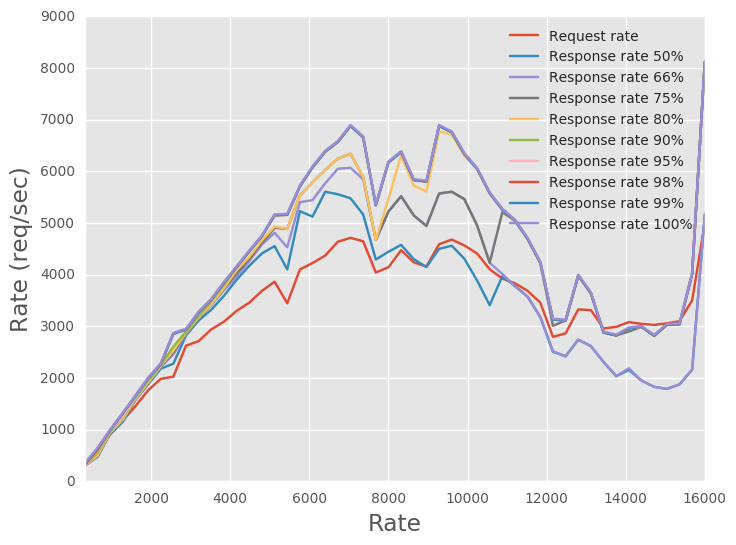

In [27]:
plot_data.plot('Rate', ['Request rate', 'Response rate 50%', 'Response rate 66%', 'Response rate 75%',
                        'Response rate 80%', 'Response rate 90%', 'Response rate 95%', 'Response rate 98%',
                        'Response rate 99%', 'Response rate 100%'], ylim=(0, None)).set_ylabel("Rate (req/sec)")

In [28]:
plot_data['Rate'].describe()

count       50.000000
mean      8160.000000
std       4664.761516
min        320.000000
25%       4240.000000
50%       8160.000000
75%      12080.000000
max      16000.000000
Name: Rate, dtype: float64

In [29]:
plot_data['Request rate'].describe()

count      50.000000
mean     3327.974000
std      1118.271141
min       320.000000
25%      2945.900000
50%      3451.800000
75%      4154.475000
max      4993.900000
Name: Request rate, dtype: float64

In [30]:
plot_data['Response rate 95%'].describe()

count      50.000000
mean     4285.740000
std      1855.515373
min       313.000000
25%      2968.500000
50%      4189.500000
75%      5825.750000
max      8114.000000
Name: Response rate 95%, dtype: float64

### 2. Response time

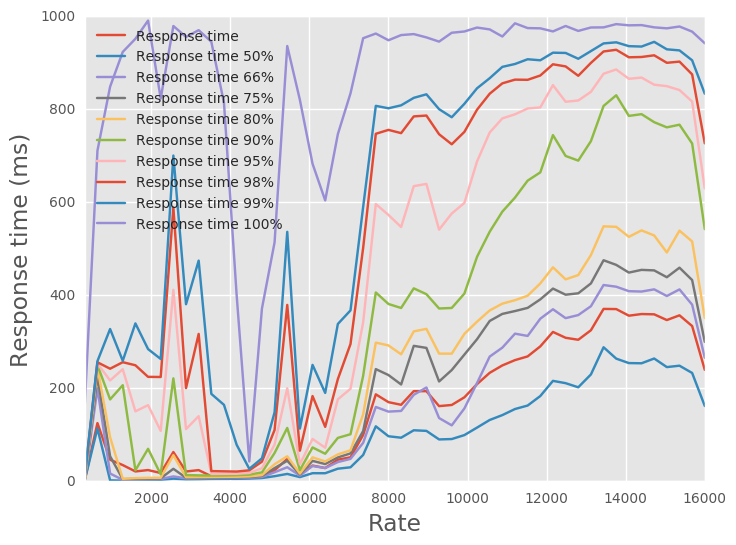

In [31]:
plot_data.plot('Rate', ['Response time', 'Response time 50%', 'Response time 66%', 'Response time 75%',
                        'Response time 80%', 'Response time 90%', 'Response time 95%', 'Response time 98%',
                        'Response time 99%', 'Response time 100%'], ylim=(0, None)).set_ylabel("Response time (ms)")

In [32]:
plot_data['Response time'].describe()

count     50.000000
mean     161.209500
std      132.222610
min        3.662500
25%       25.328125
50%      164.421875
75%      284.837500
max      370.781250
Name: Response time, dtype: float64

In [33]:
plot_data['Response time 95%'].describe()

count     50.000000
mean     464.576250
std      327.960416
min        6.312500
25%      142.765625
50%      559.906250
75%      803.593750
max      885.687500
Name: Response time 95%, dtype: float64

### 3. Success rate

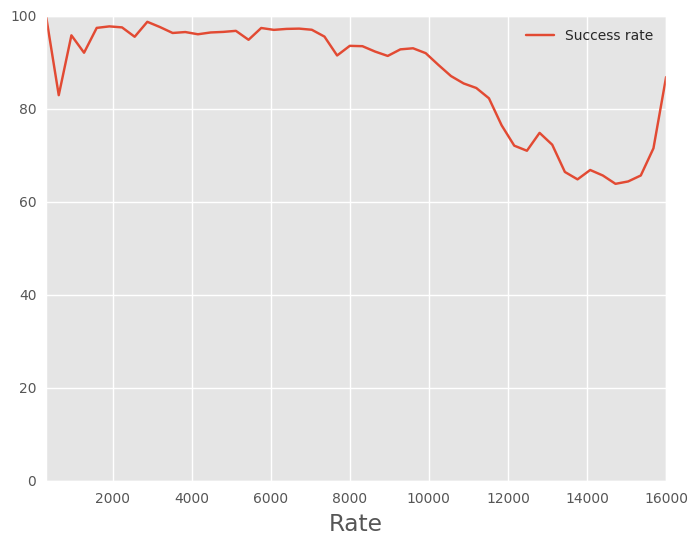

In [34]:
plot_data['Success rate'] = (plot_data['Response status 2xx'] + plot_data['Response status 3xx']) / plot_data['Number of requests'] * 100.0
plot_data.plot('Rate', 'Success rate', ylim=(0, None))

In [35]:
plot_data['Success rate'].describe()

count     50.000000
mean      87.333578
std       11.849441
min       63.977661
25%       78.020511
50%       92.660070
75%       96.644761
max      100.000000
Name: Success rate, dtype: float64

## Server side stats

In [36]:
# read in the stats data
stats_data = pd.read_csv("./results/" + run_name + "/httperf_server_stats.csv", header=0, na_filter=False)
stats_data['Connections Ratio (%)'] = stats_data['Connections'] / sum(stats_data['Connections']) * 100
stats_data['Packets Ratio (%)'] = stats_data['Packets'] / sum(stats_data['Packets']) * 100
stats_data['Bytes Ratio (%)'] = stats_data['Bytes (K)'] / sum(stats_data['Bytes (K)']) * 100
stats_data

,Server,Connections,Packets,Bytes (K),Connections Ratio (%),Packets Ratio (%),Bytes Ratio (%)
0,11.11.11.107:80,17207,557882,37101.684,25.000726,8.564477,8.518945
1,11.11.11.106:80,17207,2002853,133843.000,25.000726,30.747343,30.731791
2,11.11.11.103:80,17206,1989693,133320.000,24.999274,30.545313,30.611705
3,11.11.11.102:80,17206,1963478,131255.000,24.999274,30.142867,30.137559
